In [1]:
import pandas as pd
import numpy as np
import vectorbt as vbt
import yfinance as yf
import matplotlib.pyplot as plt
from datetime import datetime, timedelta

Matplotlib is building the font cache; this may take a moment.


In [16]:
# Parameters
initial_capital = 5000
num_portions = 10
portion_size = initial_capital / num_portions
voo_drawdown_threshold = 0.03  # 10% drawdown
voo_increase_threshold = 0.03  # 5% increase
tickers = ['VOO', 'QQQ']
start_date = '2024-01-01'  # Adjust as needed
end_date = datetime.now().strftime('%Y-%m-%d')

# Download data
print(f"Downloading data for {tickers} from {start_date} to {end_date}...")
# data = yf.download(tickers, start=start_date, end=end_date)
data = pd.read_pickle('data/voo_qqq.pkl')
# close_prices = data['Adj Close']
print("Data downloaded successfully.")

Data downloaded successfully.


In [8]:
data.head()

Price            Close                    High                     Low  \
Ticker             QQQ         VOO         QQQ         VOO         QQQ   
Date                                                                     
2024-01-02  400.211670  428.376923  403.690993  429.620548  397.875547   
2024-01-03  395.976837  425.198700  398.631077  427.380007  395.539464   
2024-01-04  393.938934  423.856354  397.229378  427.162880  393.720233   
2024-01-05  394.406158  424.399231  397.199556  426.689096  393.004485   
2024-01-08  402.557739  430.469391  402.846004  430.607558  395.489726   

Price                         Open                Volume           
Ticker             VOO         QQQ         VOO       QQQ      VOO  
Date                                                               
2024-01-02  426.748314  403.442470  428.278214  58026900  9076000  
2024-01-03  424.665700  397.567391  426.708841  47002800  4805000  
2024-01-04  423.639208  394.097993  424.744666  39432800  3945300  
2024-01-05  423.076627  394.107943  424.014278  44867900  5723100  
2024-01-08  424.784141  395.638834  424.863120  42473800  7222400

In [12]:
warm_up = 20
# Calculate 250-day rolling highest and lowest close for VOO
voo_prices = data[('Close', 'VOO')]
voo_250d_high = voo_prices.rolling(window=warm_up).max()
voo_250d_low = voo_prices.rolling(window=warm_up).min()

# Initialize position tracking
voo_portions = num_portions
qqq_portions = 0
positions = pd.DataFrame(index=data.index, columns=['VOO_portions', 'QQQ_portions', 'VOO_value', 'QQQ_value', 'Total_value'])

In [18]:
# Strategy implementation
for i in range(warm_up, len(data)):
    current_date = data.index[i]
    prev_date = data.index[i-1]
    
    # Check conditions only if we have at least one day of previous data
    if i > warm_up:
        # Check for VOO 10% drawdown from 250d high
        if voo_prices[current_date] <= voo_250d_high[prev_date] * (1 - voo_drawdown_threshold) and voo_portions >= 2:
            # Sell 2 portions of VOO and buy QQQ
            voo_portions -= 2
            qqq_portions += 2
            print(f"{current_date}: VOO 10% drawdown detected. Selling 2 VOO portions, buying 2 QQQ portions.")
        
        # Check for VOO 5% increase from 250d low
        elif voo_prices[current_date] >= voo_250d_low[prev_date] * (1 + voo_increase_threshold) and qqq_portions >= 1:
            # Sell 1 portion of QQQ and buy VOO
            qqq_portions -= 1
            voo_portions += 1
            print(f"{current_date}: VOO 5% increase detected. Selling 1 QQQ portion, buying 1 VOO portion.")
    
    # Calculate current values
    voo_value = voo_portions * portion_size * (voo_prices[current_date] / voo_prices[data.index[warm_up]])
    qqq_value = qqq_portions * portion_size * (data[('Close', 'QQQ')][current_date] / data[('Close', 'QQQ')][data.index[warm_up]]) if qqq_portions > 0 else 0
    total_value = voo_value + qqq_value
    
    # Store positions
    positions.loc[current_date] = [voo_portions, qqq_portions, voo_value, qqq_value, total_value]

2024-02-01 00:00:00: VOO 5% increase detected. Selling 1 QQQ portion, buying 1 VOO portion.
2024-02-02 00:00:00: VOO 5% increase detected. Selling 1 QQQ portion, buying 1 VOO portion.


C:\Users\User\AppData\Local\Temp\ipykernel_4824\2676072049.py:28: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '505.88766165310403' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  positions.loc[current_date] = [voo_portions, qqq_portions, voo_value, qqq_value, total_value]


2024-04-15 00:00:00: VOO 10% drawdown detected. Selling 2 VOO portions, buying 2 QQQ portions.
2024-04-16 00:00:00: VOO 10% drawdown detected. Selling 2 VOO portions, buying 2 QQQ portions.
2024-04-17 00:00:00: VOO 10% drawdown detected. Selling 2 VOO portions, buying 2 QQQ portions.
2024-04-18 00:00:00: VOO 10% drawdown detected. Selling 2 VOO portions, buying 2 QQQ portions.
2024-04-19 00:00:00: VOO 10% drawdown detected. Selling 2 VOO portions, buying 2 QQQ portions.
2024-04-29 00:00:00: VOO 5% increase detected. Selling 1 QQQ portion, buying 1 VOO portion.
2024-05-03 00:00:00: VOO 5% increase detected. Selling 1 QQQ portion, buying 1 VOO portion.
2024-05-06 00:00:00: VOO 5% increase detected. Selling 1 QQQ portion, buying 1 VOO portion.
2024-05-07 00:00:00: VOO 5% increase detected. Selling 1 QQQ portion, buying 1 VOO portion.
2024-05-08 00:00:00: VOO 5% increase detected. Selling 1 QQQ portion, buying 1 VOO portion.
2024-05-09 00:00:00: VOO 5% increase detected. Selling 1 QQQ port

In [19]:
positions

,VOO_portions,QQQ_portions,VOO_value,QQQ_value,Total_value
Date,,,,,
2024-01-02,0,0,0.0,0.000000,0.000000
2024-01-03,0,0,0.0,0.000000,0.000000
2024-01-04,0,0,0.0,0.000000,0.000000
2024-01-05,0,0,0.0,0.000000,0.000000
2024-01-08,0,0,0.0,0.000000,0.000000
...,...,...,...,...,...
2025-03-06,0,10,0.0,5888.927247,5888.927247
2025-03-07,0,10,0.0,5932.231685,5932.231685
2025-03-10,0,10,0.0,5702.319895,5702.319895


In [21]:
# Fill NaN values with 0
positions = positions.fillna(0)

# Calculate strategy returns
strategy_returns = positions['Total_value'].pct_change().fillna(0)

# Create benchmark (100% VOO)
benchmark_value = initial_capital * (voo_prices / voo_prices[data.index[warm_up]])
benchmark_returns = benchmark_value.pct_change().fillna(0)

# Trim data to start from day 250 (when we have enough data for the strategy)
start_idx = warm_up
strategy_returns = strategy_returns[start_idx:]
benchmark_returns = benchmark_returns[start_idx:]

In [23]:
benchmark_returns

Date
2024-01-31   -0.016291
2024-02-01    0.013159
2024-02-02    0.010274
2024-02-05   -0.003654
2024-02-06    0.003115
                ...   
2025-03-06   -0.018140
2025-03-07    0.005392
2025-03-10   -0.026440
2025-03-11   -0.008205
2025-03-12    0.004851
Name: (Close, VOO), Length: 279, dtype: float64

In [30]:
# Convert to vectorbt PortfolioStats
strategy_rets = strategy_returns.vbt.to_returns()
benchmark_rets = benchmark_returns.vbt.to_returns()
# strategy_rets = vbt.returns.Returns(strategy_reretturns)
# benchmark_rets = vbt.returns.Returns(benchmark_urns)
strategy_stats = strategy_rets.vbt.stats()
benchmark_stats = benchmark_rets.vbt.stats()

In [31]:
strategy_stats

Start        2024-01-31 00:00:00
End          2025-03-12 00:00:00
Period                       279
Count                        277
Mean                   -0.232399
Std                    16.701945
Min                  -232.867786
Median                 -0.200298
Max                    79.917842
Min Index    2025-02-27 00:00:00
Max Index    2025-02-18 00:00:00
Name: Total_value, dtype: object

In [32]:
benchmark_stats

Start        2024-01-31 00:00:00
End          2025-03-12 00:00:00
Period                       279
Count                        278
Mean                    -0.54053
Std                    36.657192
Min                   -571.44939
Median                 -0.175047
Max                   135.268104
Min Index    2024-12-27 00:00:00
Max Index    2024-05-09 00:00:00
Name: (Close, VOO), dtype: object


--- Strategy Performance ---
Final Portfolio Value: $5752.86
Total Return: 15.06%
VOO Portions: 0
QQQ Portions: 10

--- Comparison with Benchmark ---


C:\Users\User\AppData\Local\Temp\ipykernel_4824\546643138.py:3: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print(f"Final Portfolio Value: ${positions['Total_value'][-1]:.2f}")
C:\Users\User\AppData\Local\Temp\ipykernel_4824\546643138.py:4: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print(f"Total Return: {(positions['Total_value'][-1] / initial_capital - 1) * 100:.2f}%")
C:\Users\User\AppData\Local\Temp\ipykernel_4824\546643138.py:5: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). 

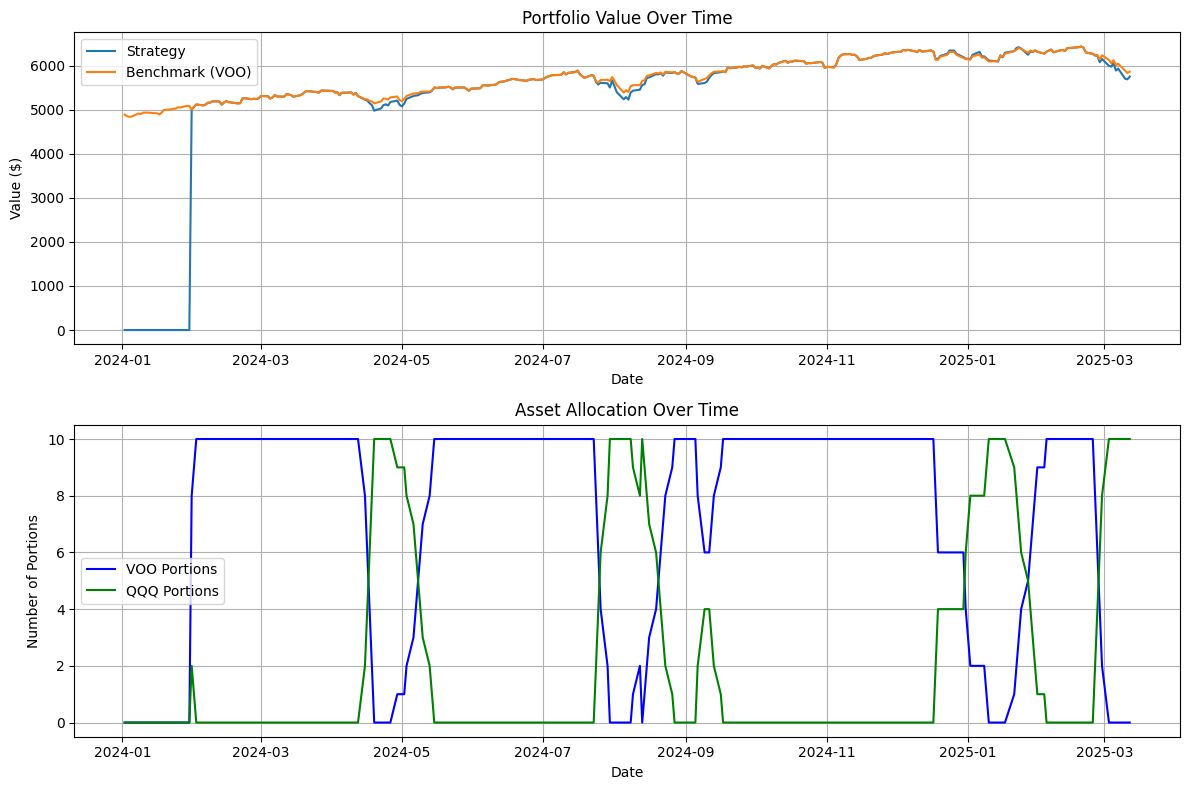


--- Detailed Performance Report ---


C:\Users\User\AppData\Local\Temp\ipykernel_4824\546643138.py:45: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  f"{(positions['Total_value'][-1] / initial_capital - 1) * 100:.2f}%",


KeyError: 'yearly_return'

In [ ]:
# Display results
print("\n--- Strategy Performance ---")
print(f"Final Portfolio Value: ${positions['Total_value'][-1]:.2f}")
print(f"Total Return: {(positions['Total_value'][-1] / initial_capital - 1) * 100:.2f}%")
print(f"VOO Portions: {positions['VOO_portions'][-1]}")
print(f"QQQ Portions: {positions['QQQ_portions'][-1]}")

print("\n--- Comparison with Benchmark ---")
# print(f"Strategy Sharpe Ratio: {strategy_stats['sharpe_ratio']:.2f}")
# print(f"Benchmark Sharpe Ratio: {benchmark_stats['sharpe_ratio']:.2f}")
# print(f"Strategy Max Drawdown: {strategy_stats['max_drawdown'] * 100:.2f}%")
# print(f"Benchmark Max Drawdown: {benchmark_stats['max_drawdown'] * 100:.2f}%")
# print(f"Strategy CAGR: {strategy_stats['yearly_return'] * 100:.2f}%")
# print(f"Benchmark CAGR: {benchmark_stats['yearly_return'] * 100:.2f}%")

# Plot performance
plt.figure(figsize=(12, 8))
plt.subplot(2, 1, 1)
plt.plot(positions['Total_value'], label='Strategy')
plt.plot(benchmark_value[benchmark_value.index >= positions.index[0]], label='Benchmark (VOO)')
plt.title('Portfolio Value Over Time')
plt.xlabel('Date')
plt.ylabel('Value ($)')
plt.legend()
plt.grid(True)

plt.subplot(2, 1, 2)
plt.plot(positions['VOO_portions'], label='VOO Portions', color='blue')
plt.plot(positions['QQQ_portions'], label='QQQ Portions', color='green')
plt.title('Asset Allocation Over Time')
plt.xlabel('Date')
plt.ylabel('Number of Portions')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.savefig('voo_qqq_strategy_results.png')
plt.show()

# Create a more detailed performance report
print("\n--- Detailed Performance Report ---")
# report_df = pd.DataFrame({
#     'Metric': ['Total Return', 'CAGR', 'Sharpe Ratio', 'Max Drawdown', 'Volatility'],
#     'Strategy': [
#         f"{(positions['Total_value'][-1] / initial_capital - 1) * 100:.2f}%",
#         f"{strategy_stats['yearly_return'] * 100:.2f}%",
#         f"{strategy_stats['sharpe_ratio']:.2f}",
#         f"{strategy_stats['max_drawdown'] * 100:.2f}%",
#         f"{strategy_stats['yearly_vol'] * 100:.2f}%"
#     ],
#     'Benchmark (VOO)': [
#         f"{(benchmark_value[-1] / initial_capital - 1) * 100:.2f}%",
#         f"{benchmark_stats['yearly_return'] * 100:.2f}%",
#         f"{benchmark_stats['sharpe_ratio']:.2f}",
#         f"{benchmark_stats['max_drawdown'] * 100:.2f}%",
#         f"{benchmark_stats['yearly_vol'] * 100:.2f}%"
#     ]
# })

# print(report_df.to_string(index=False))